In [18]:
from classication_dataset import ClassificationDataset, get_data_loaders
from architectures.simple_CNN import SimpleCNN, train_model
import torch
import numpy as np
import os
import cv2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from gradcam.utils import visualize_cam
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import (
    show_cam_on_image, deprocess_image, preprocess_image
)


In [2]:
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)

cuda_device = "cuda:2"

Quadro RTX 6000
Quadro RTX 6000
Quadro RTX 6000


In [3]:
train_loader, val_loader, test_loader = get_data_loaders(
    img_dir="data/PANNUKE/images",
    
    label_file="data/PANNUKE/labels/labels.npy",
    contiguous_ids_file="data/PANNUKE/labels/contiguous_ids.npy",
    
    batch_size=64,
    val_split=0.2,
    test_split=0.1
)

In [4]:
model = SimpleCNN()

In [5]:
train_model(model, train_loader, val_loader, cuda_device, learning_rate=0.001)

Training for epoch 0: 100%|██████████| 23/23 [00:17<00:00,  1.32it/s]


Epoch 1/1000
Train loss: 0.7633671941964523
Val loss: 0.6926110823949178


Training for epoch 1: 100%|██████████| 23/23 [00:16<00:00,  1.37it/s]


Epoch 2/1000
Train loss: 0.6936085250066675
Val loss: 0.6931576225492689
No progress on val loss was made, patience reduced to 2.


Training for epoch 2: 100%|██████████| 23/23 [00:17<00:00,  1.30it/s]


Epoch 3/1000
Train loss: 0.6931565689003986
Val loss: 0.6930937621328566
No progress on val loss was made, patience reduced to 1.


Training for epoch 3: 100%|██████████| 23/23 [00:18<00:00,  1.27it/s]


Epoch 4/1000
Train loss: 0.6932509126870529
Val loss: 0.6930651836925082
No progress on val loss was made, patience reduced to 0.
Patience dropped to 0, changed learning rate to 0.0001.


Training for epoch 4: 100%|██████████| 23/23 [00:17<00:00,  1.28it/s]


Epoch 5/1000
Train loss: 0.6931444251019022
Val loss: 0.6930723163816664
No progress on val loss was made, patience reduced to 2.


Training for epoch 5:  57%|█████▋    | 13/23 [00:10<00:08,  1.19it/s]


KeyboardInterrupt: 

In [6]:
trained_model_path = "models/simple_CNN_46"
model = SimpleCNN()
model.load_state_dict(torch.load(trained_model_path, weights_only=True))
model.eval()
model.to(torch.device("cuda:0"))

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_run

Accuracy on test set: 65.00%


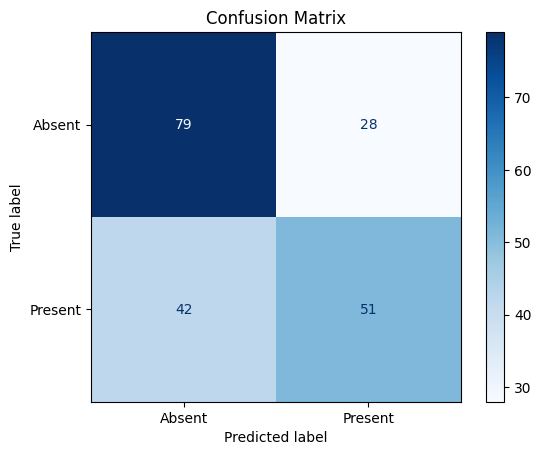

In [15]:

model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
device = torch.device("cuda:0")
all_predictions = []
all_labels = []
all_inputs_tensors = []

    
# Disabling gradient calculation for evaluation
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Get predicted class (the one with the highest score)
        _, predicted = torch.max(outputs, 1)

        # Update the total number of samples and correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predicted.cpu().numpy())
        all_inputs_tensors.append(inputs.cpu().numpy())

# Flatten the lists to arrays
all_predictions = np.concatenate(all_predictions)
all_labels = np.concatenate(all_labels)
all_inputs_tensors = np.concatenate(all_inputs_tensors)

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy on test set: {accuracy:.2f}%')

cm = confusion_matrix(all_labels, all_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Absent', 'Present'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [8]:
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_run

In [14]:
config = dict(arch=model, layer_name='conv6')
config['arch'].to(device).eval()
cam = [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]


TypeError: GradCAM.from_config() missing 1 required positional argument: 'model_type'

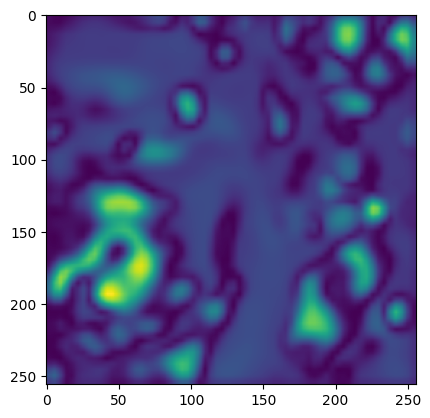

In [35]:
target_layers = [model.conv6]
rgb_img = cv2.imread("data/PANNUKE/images/0.png", 1)[:, :, ::-1]
rgb_img = np.float32(rgb_img) / 255
input_tensor = preprocess_image(rgb_img,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]).to(cuda_device)
targets = None
methods = {
    "gradcam": GradCAM,
    "gradcam++": GradCAMPlusPlus
}
output_dir = "CAM_outputs"
cam_algorithm = methods["gradcam++"]
method = GradCAM

with cam_algorithm(model=model, target_layers=target_layers) as cam:
    # AblationCAM and ScoreCAM have batched implementations.
    # You can override the internal batch size for faster computation.
    cam.batch_size = 32
    grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets,
                        aug_smooth=True,
                        eigen_smooth=True
                        )

    grayscale_cam = grayscale_cam[0, :]

    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    cam_image = cv2.cvtColor(cam_image, cv2.COLOR_BGR2RGB)

plt.imshow(grayscale_cam)
plt.show()

In [37]:
grayscale_cam = cv2.normalize(grayscale_cam, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

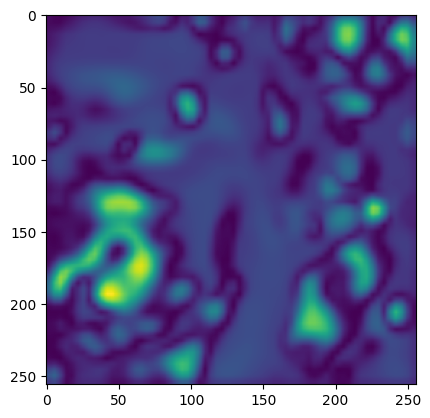

In [38]:
plt.imshow(grayscale_cam)
plt.show()

In [41]:
print()

KeyboardInterrupt: 